In [16]:
y_true = []
with open('submit_sample.txt', 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_true.append(int(pro[1]))

In [17]:
print(len(y_true), y_true[0:10])

1586 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [21]:
scoreFile1 = 'predict/predict-lstm-1.txt'
scoreFile2 = 'predict/predict-blstm-1.txt'
scoreFile3 = 'predict/predict-blstm-word2vec-1.txt'
scoreFile4 = 'predict/predict-blstm-word2vec-attention-1.txt'

y_pred_lstm = []
with open(scoreFile1, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_pred_lstm.append(float(pro[1]))

y_pred_blstm = []
with open(scoreFile2, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_pred_blstm.append(float(pro[1]))

y_pred_blstm_word2vec = []
with open(scoreFile3, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_pred_blstm_word2vec.append(float(pro[1]))

y_pred_blstm_word2vec_attention = []
with open(scoreFile4, 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_pred_blstm_word2vec_attention.append(float(pro[1]))

In [26]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred_lstm[i]: num += 1
print(num)
print(num / len(y_true))

1131
0.7131147540983607


In [27]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred_blstm[i]: num += 1
print(num)
print(num / len(y_true))

1112
0.7011349306431274


In [28]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred_blstm_word2vec[i]: num += 1
print(num)
print(num / len(y_true))

1158
0.7301387137452712


In [29]:
num = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred_blstm_word2vec_attention[i]: num += 1
print(num)
print(num / len(y_true))

1150
0.725094577553594


### MRR MAP ACC-1 评估
![alt text](img/mrr.jpg "title")
![alt text](img/map.jpg "title")
![alt text](img/acc.jpg "title")

In [7]:
import json

with open('test_data_sample.json', 'r') as f:
    data = json.load(f)

qIndex2aIndex = {} # 问题到答案的映射
aIndex2qIndex = {} # 答案到问题的映射
for qa in data:
    item_id = qa['item_id']
    qIndex2aIndex[item_id] = []
    for passage in qa['passages']:
        passage_id = passage['passage_id']
        qIndex2aIndex[item_id].append(passage_id)
        aIndex2qIndex[passage_id] = item_id

In [8]:
class Evaluator(object):
    qIndex2aIndex2aLabel = {} # 问题到答案到标签的映射
    qIndex2aIndex2aScore = {} # 问题到答案到分数的映射
    MRRList = []
    MAPList = []
    ACC_1List = []

    def __init__(self, qaPairFile, scoreFile):
        self.loadData(qaPairFile, scoreFile)

    def loadData(self, qaPairFile, scoreFile):
        qaPairLines = open(qaPairFile, 'r').readlines()
        scoreLines = open(scoreFile, 'r').readlines()
        assert len(qaPairLines) == len(scoreLines)
        
        for idx in range(len(qaPairLines)):
            qaLine = qaPairLines[idx].strip()
            scLine = scoreLines[idx].strip()
            qaLineArr = qaLine.split(',')
            scLineArr = scLine.split(',')
            
            assert qaLineArr[0] == scLineArr[0]
            assert len(qaLineArr) == 2
            assert len(scLineArr) == 2
            
            label = int(qaLineArr[1])
            score = float(scLineArr[1])
            aIndex = int(qaLineArr[0])
            qIndex = aIndex2qIndex[aIndex]
            
            if not qIndex in self.qIndex2aIndex2aScore:
                self.qIndex2aIndex2aScore[qIndex] = {}
                self.qIndex2aIndex2aLabel[qIndex] = {}
            self.qIndex2aIndex2aLabel[qIndex][aIndex] = label
            self.qIndex2aIndex2aScore[qIndex][aIndex] = score

    def calculate(self):
        # 对同一个问题分析答案
        for qIndex, index2label in self.qIndex2aIndex2aLabel.items():
            index2score = self.qIndex2aIndex2aScore[qIndex]
            rankedList = sorted(index2score.items(), key=lambda b: b[1], reverse=True) # 按照降序排序
            
            rankIndex = 0
            collectNum = 0
            collectList = []
            acc1 = 0
            for info in rankedList:
                aIndex = info[0]
                label = index2label[aIndex]
                rankIndex += 1
                if label == 1:
                    if rankIndex == 1: acc1 = 1 # TOP-1
                    collectNum += 1
                    p = float(collectNum) / rankIndex
                    collectList.append(p)
            self.MRRList.append(collectList[0])
            self.MAPList.append(float(sum(collectList)) / len(collectList))
            self.ACC_1List.append(acc1)

    def MRR(self):
        return float(sum(self.MRRList)) / len(self.MRRList)

    def MAP(self):
        return float(sum(self.MAPList)) / len(self.MAPList)

    def ACC_1(self):
        return float(sum(self.ACC_1List)) / len(self.ACC_1List)


def evaluate(qaPairFile, scoreFile):
    testor = Evaluator(qaPairFile, scoreFile)
    testor.calculate()
    print("MRR:%f \t MAP:%f \t ACC_1:%f\n" % (testor.MRR(), testor.MAP(), testor.ACC_1()))

In [12]:
qaPairFile = 'submit_sample.txt'
scoreFile1 = 'predict/predict-lstm-1.txt'
scoreFile2 = 'predict/predict-blstm-1.txt'
scoreFile3 = 'predict/predict-blstm-word2vec-1.txt'
scoreFile4 = 'predict/predict-blstm-word2vec-attention-1.txt'

evaluate(qaPairFile, scoreFile1)
evaluate(qaPairFile, scoreFile2)
evaluate(qaPairFile, scoreFile3)
evaluate(qaPairFile, scoreFile4)

MRR:0.401873 	 MAP:0.373016 	 ACC_1:0.224000

MRR:0.435249 	 MAP:0.394119 	 ACC_1:0.256667

MRR:0.462888 	 MAP:0.412843 	 ACC_1:0.282857

MRR:0.475899 	 MAP:0.421312 	 ACC_1:0.296250



## 线性回归 拟合

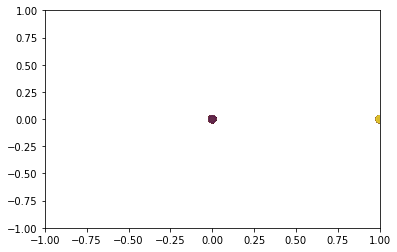

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

X = y_pred
Y = [0] * len(y_pred)
T = y_true

plt.scatter(X, Y, s=50, c=T, alpha=.5)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.array(y_pred).reshape(-1, 1)
y = y_true
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

# 训练
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# 测试
y_ = lr.predict(X_test)
accuracy_score(y_test, y_)

0.7352941176470589

In [37]:
print(lr.predict(0.50))
print(lr.predict(0.51))

[0]
[0]
